# Amazon Bedrock Multimodal Workshop
## Getting started
This notebook focuses on getting started with Amazon Titan Multimodal Embeddings.

You will explore how to get embeddings for images, text or both and how to store these in a vector database and perform search queries using vectors.

### Import needed libraries

In [ ]:
import os
import json
import boto3
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from langchain.vectorstores import FAISS
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

### Amazon Bedrock Titan Multimodal Embeddings (TMME)
In this section of the notebook we will create the functions needed to retrieve embeddings using Amazon Bedrock TMME. 

#### Define output embedding length
Titan Multimodal Embeddings gives you the option to create embeddings with three vector sizes: 1024, 384 or 256

In [ ]:
outputEmbeddingLength = 1024 # Define output vector size – 1,024 (default), 384, 256

#### Text embeddings
This function will transform an text into an embeddings vector using TMME. 

In [ ]:
def get_embeddings_of_text(text, outputEmbeddingLength = outputEmbeddingLength):
    body = json.dumps(
        {
            "inputText": text,
            "embeddingConfig": {
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )
    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )
    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

#### Image embeddings
This function will transform an image into an embeddings vector using TMME. 

In [ ]:
def get_embeddings_of_image(image, outputEmbeddingLength = outputEmbeddingLength):
    with open(image, "rb") as image_file:
        imageEncoded = base64.b64encode(image_file.read()).decode('utf8')

    body = json.dumps(
        {
            "inputImage": imageEncoded,
            "embeddingConfig": { 
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    response = bedrock_runtime.invoke_model(
        body=body, 
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"       
    )
    
    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

#### Image + Text embeddings
This function will transform an image + text into an embeddings vector using TMME. 

In [ ]:
def get_embeddings_of_image_and_text(image, text, outputEmbeddingLength = outputEmbeddingLength):
    with open(image, "rb") as image_file:
        imageEncoded = base64.b64encode(image_file.read()).decode('utf8')

    body = json.dumps(
        {
            "inputImage": imageEncoded,
            "inputText": text,
            "embeddingConfig": {
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )

    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

### Store embeddings in a vector database
Now we know how to get embeddings for our content, we are going to store them in a vector database to later on query and retrieve results. 

In this case we are going to use FAISS.

#### Create and store images into the vector database

Create embeddings and associated metadata for all the images in the "images" folder. 

In [40]:
images_folder = "base-images"
images_items = []

for file in os.listdir(images_folder):
    if file.endswith(".png") or file.endswith(".jpg"):
        file_path = os.path.join(images_folder, file)
        vector = get_embeddings_of_image(file_path)
        images_items.append((file, vector["embedding"]))

Populate the vector database with the images items.

In [41]:
metadata = [{"image_name": item[0]} for item in images_items]
embeddings = [("", item[1]) for item in images_items]
index = FAISS.from_embeddings(
        text_embeddings=embeddings,
        embedding=None,
        metadatas=metadata
    )

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


### Query the database
In this section we will focus on querying our populated vector database.
To search against the database you first need to transform the input (text or image) into a vector and the perform the search using the embeddings vector.

#### Display results
With this function we will display the results we retrieve from querying the database.

In [42]:
def display_images_faiss_results(image_data):
    # Create a subplot with 1 row and the number of images as columns
    num_images = len(image_data)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))

    # Iterate over each image data entry and display the image and description
    for i, entry in enumerate(image_data):
        image_name = entry[0].metadata['image_name']
        score = entry[1]
        
        # Load and display the image
        img = mpimg.imread(f'{images_folder}/{image_name}')
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].text(0.5, -0.1, image_name, ha='center', transform=axes[i].transAxes)

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

#### Text query
With this function we will first transform our text query into an embeddings vector, which we will then use to query the vector database. 

In [43]:
def query_the_database_with_text(text):
    vector = get_embeddings_of_text(text)["embedding"]
    results = index.similarity_search_with_score_by_vector(embedding=vector)
    return results

[(Document(page_content='', metadata={'image_name': 'goat.jpg'}), 1.0998446), (Document(page_content='', metadata={'image_name': 'giraffe.jpg'}), 1.2635458), (Document(page_content='', metadata={'image_name': 'chick.jpg'}), 1.3065734), (Document(page_content='', metadata={'image_name': 'tiger.jpg'}), 1.3986944)]


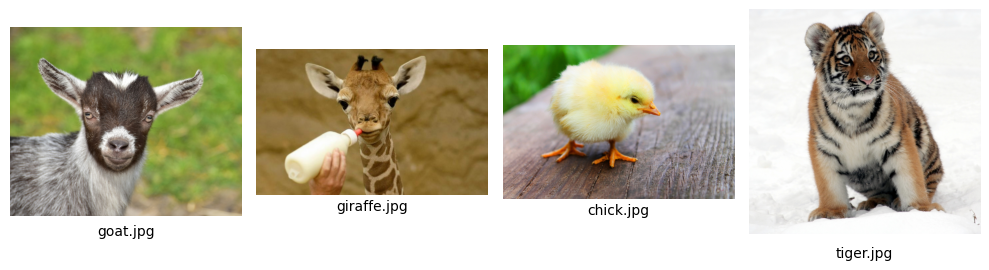

In [50]:
results = query_the_database_with_text("A goat")
print(results)
display_images_faiss_results(results)

#### Image query
With this function we will first transform our image query into an embeddings vector, which we will then use to query the vector database. 

In [53]:
def query_the_database_with_image(image):
    vector = get_embeddings_of_image(image)["embedding"]
    results = index.similarity_search_with_score_by_vector(embedding=vector)
    return results

In [58]:
test_image = "test-images/tiger.jpg"

[(Document(page_content='', metadata={'image_name': 'tiger.jpg'}), 0.52965224), (Document(page_content='', metadata={'image_name': 'chick.jpg'}), 0.9688066), (Document(page_content='', metadata={'image_name': 'elephants.jpg'}), 1.0113461), (Document(page_content='', metadata={'image_name': 'goat.jpg'}), 1.0845205)]


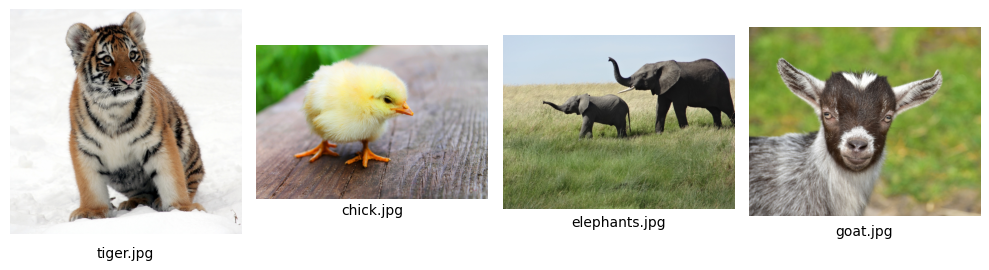

In [59]:
results = query_the_database_with_image(test_image)
print(results)
display_images_faiss_results(results)